In [1]:
import os
from dotenv import load_dotenv
from pprint import pprint

from stravalib import Client

load_dotenv(override=True)

True

In [2]:
client = Client(
    access_token=os.getenv("STRAVA_ACCESS_TOKEN"),
    token_expires=int(os.getenv("STRAVA_TOKEN_EXPIRES")),
    refresh_token=os.getenv("STRAVA_REFRESH_TOKEN"),
)
athlete = client.get_athlete()

In [ ]:
# https://stravalib.readthedocs.io/en/latest/reference/api/stravalib.model.DetailedAthlete.html#stravalib.model.DetailedAthlete
print(athlete.id)
print(athlete.firstname)
print(athlete.lastname)
print(athlete.sex)
print(athlete.athlete_type)
print(athlete.follower_count)
print(athlete.bikes)
print(athlete.shoes)

In [ ]:
# athlete.model_dump()

In [ ]:
# https://stravalib.readthedocs.io/en/latest/reference/api/stravalib.model.AthleteStats.html#stravalib.model.AthleteStats
print(athlete.stats.all_run_totals)
print(athlete.stats.ytd_run_totals)
print(athlete.stats.recent_run_totals)
print(athlete.stats.biggest_ride_distance)

In [ ]:
athlete.stats.model_dump()

In [4]:
activities = client.get_activities(limit=15)

In [ ]:
for activity in activities:
    print(f"{activity.name} | {activity.kudos_count} | {activity.distance} | {activity.average_heartrate}")

In [ ]:
for activity in activities:
    print(activity.model_dump())
    break

In [5]:
import polars as pl

data = []
for activity in activities:
    data.append(activity.model_dump())

df = pl.DataFrame(data)
df

id,achievement_count,athlete,athlete_count,average_speed,average_watts,comment_count,commute,device_watts,distance,elapsed_time,elev_high,elev_low,end_latlng,external_id,flagged,gear_id,has_kudoed,hide_from_home,kilojoules,kudos_count,manual,map,max_speed,max_watts,moving_time,name,photo_count,private,sport_type,start_date,start_date_local,start_latlng,timezone,total_elevation_gain,total_photo_count,trainer,type,upload_id,upload_id_str,weighted_average_watts,workout_type,utc_offset,location_city,location_state,location_country,pr_count,suffer_score,has_heartrate,average_heartrate,max_heartrate,average_cadence,from_accepted_tag,visibility
i64,i64,struct[2],i64,f64,null,i64,bool,null,f64,i64,f64,f64,list[f64],str,bool,str,bool,null,null,i64,bool,struct[3],f64,null,i64,str,i64,bool,str,"datetime[μs, UTC]","datetime[μs, UTC]",list[f64],str,f64,i64,bool,str,i64,str,null,null,f64,null,null,null,i64,null,bool,f64,i64,f64,bool,str
16732644275,78,"{88953196,1}",4,5.812,null,1,false,null,110065.0,24922,233.6,33.2,"[43.832786, 4.365855]","""garmin_ping_512227400285""",false,"""b15029677""",false,null,null,15,false,"{""a16732644275"",null,""ebpjG_vsYab@gi@dLc_CfEv@gEsAL{BxKkCpSfKdLuNnCw_@rQuf@hIcLkBq`@bBqDmFyRB}H}XmFuXac@kGoB{]}`@kQeI}^w@kk@jHse@wGoRn@A{FgCeAyQcr@wDbAvDc@qJeW|EsE~DbK{Sg|@}b@mpA{NrGsYp@gb@mLoGwJoMsG_Z~Dca@qEqOvJsDVmFwLeMdMiOXgMiKeJ{Bao@x@sDvMcZoCuAqEeNeJsFl@eAfGwDmBiE`KqJoOsBeTsWaAcD_JaLeBuAoEgDj@yEcM_a@qNaJ`k@uM{JuNyVuOzFs^dHWtI_P`Kuo@vCyVllAkObdByQeAmSwLm_@jSo`@cQ{N~GoPeDyHyJz@yRqXsYeKs[QkM}LbEyAuBtAuD{k@}FwArMyDHiTuY}J{TuFwMwA_QkLrScR|AcFoDaGa`@wKkBt@iMcBAsAtFpB}GFhNgC|@cC|I|G|QcPxVrCzh@j@t]cEbv@}@g@fApBe@ph@mEpR|JpAo@vX}ZnD}Jbd@g]yOmBeGeTmRmN@qc@gTsP_VcKoDoHlAsJyFRgGof@Kwm@c^iYkI_QO}TdI_k@{O_AoInGkCaG{@sAgLM}\zB_TaBw^sB_PkH{RYyPoAkEoB?EaKkCcJmXgEaAkFwBJw@eTbBsMyEoDwDmUiEcIr@i^l@uJpYo{ApScZpJ{d@fUwn@hf@cg@tJk[lGuIxAlUoG`JjBhH}Ip\fC|E_C|LjKhF{BdGpB|ArX}MnEjIgBnUdRbI`KqBi@fXbEtV~@fb@fHlPgDjJf@`KpD`Cs@rFzk@zQda@~b@vK|WrFr`@`EzFtLzHhQpgAfJpOnNbHjJpShGj\~LlX`SlSn`@`KcC`V`@xq@hQtJh]]xIaHnWpChMdIzQrZhUrLdLto@hCrApE_HbHMnAxHqA`OjL~Ns@hLjDzKvJpAhByKzU`QffBv_@jf@kOxJ`VRaQ~EmGxGcA~@iIbGqEtORjDeEj`@gK|Vh@~BwC`AiRvGcIzJwCpm@|BrAdMrFdEdCvJRtUsCzBRxGaExJxBrYyCrUrEfp@vG~XfDl`@k@dWtAfRzExLjNR|RbPnH_JcFsNxAyGhMJ~UcTrLu@zGjBjMm[bC}ClLgAzGcH`BkJxJ`CpCfGvMlBhDdKhHjG~VpBvz@ga@pKyPtHiB~StMjVfd@~ZtOz]xc@~MxB~h@wErZhUxc@mIhUpFn[_HtOuFlG|D|NbZ`QlGbW`RnTp\eAbd@t@bOlCdHpJ}A`TeSlAwEcCiDx@gLjHcQ""}",18.58,null,18938,"""100 km au Nord de Nîmes 🥳""",0,false,"""Ride""",2025-12-13 07:53:25 UTC,2025-12-13 08:53:25 UTC,"[43.832839, 4.36592]","""(GMT+01:00) Europe/Paris""",1165.7,1,false,"""Ride""",17822837619,"""17822837619""",null,null,3600.0,null,null,null,32,null,true,124.0,170,null,false,"""everyone"""
16713574330,6,"{88953196,1}",1,6.064,null,0,false,null,22080.7,3835,143.0,83.8,"[44.043443, 4.453287]","""garmin_ping_511511549546""",false,"""b15029677""",false,null,null,13,false,"{""a16713574330"",null,""}iykGcydZrAdAJ\X|CAlB]lLBbHCjEJlDEZ_@j@k@h@U\IZq@|FEJCEDCCAF\g@hD@HRLhBErET`@PJTUnGWlDGtCCfFKZSRg@LkHTgF|AyBDcDIMNm@jF[tAcA~Cu@pBmAzI_A`DSrACZFvBX|AvAzFDfAK`Aw@zCQdA{@jJOvCD|Ft@rQPvAf@`C`CtJ^nBJfBRhIRxC|@nKl@zDV|Bn@|It@|Hb@vCZjARXj@`@NX@x@\nB@jEZbDVzECzB[~H[lKGnI@dDPbBrDzP`AnFz@`KDjB@xCq@vM@jBT|CFdKPnD?vAgAlUBPNFnFT~AG~CiA|EgC|Cy@lJgDfDuCbCeAxCYxG}BdD_@vCw@v@?jAXf@V|@t@fCfBXYj@Cl@Rf@^j@`A^L^Hx@CpAI~A[`@DbBkG~EyPF]?SOQq@O_AM[BeBb@sBjAGA[c@iCIBeABOF@cAA}AUMGEYLwCL_AdDiFxA}C`@Wf@iIXsGJIbBp@tElAbA^v@b@nA^NLD^LVf@NZTz@lB^JTKL[DgB`@qBxAmFpQmn@fAgEhCaJr@sATeB|Jm]vOij@N_@JPg@nF?XJPlFpAlBTzGJJMIg@KEUs@AU]kBa@kDQEmDh@QKEe@DWr@i@bAuAd@]xBc@fAFPIFUB{@IcAAoBCc@]wCvAw@PUTa@r@yB@g@SgBEcCe@oBy@iBaAiBSIwBL{@u@iAIk@BiA[KBKl@i@fHJ|A\|@APG@GMKEED[CIH@Kq@SuBNi@\`@Jt@Cp@@TRCIFE_DBdAq@b@CxARcCLMIeB^^Qz@MjDa@UND?XKw@BPEEDR?eFv@mCRlCi@AKXGpAChHs@k@NL@{@LS@FEYEe@Dm@[SDw@[uB]QSa@SU[BKc@MSm@Yg@W_A_@c@QIqBSaA^cCDeDT{B?iBOuBg@sC_AkC_BsAyAwAm@YBe@XYC}@s@Yq@[oBGiAA}BO{Ae@}AI_AUk@McCIWQOsFkCcDsBcDi@yEM[KuBaCuEuC}BiCO[Cc@AeCDu@C]MSgDAqAMuG{DcAi@wCw@sB}@sAa@yACyA[eB{A{FeEgDkE}@oAw@wAS

In [29]:
df.columns

['id',
 'achievement_count',
 'athlete',
 'athlete_count',
 'average_speed',
 'average_watts',
 'comment_count',
 'commute',
 'device_watts',
 'distance',
 'elapsed_time',
 'elev_high',
 'elev_low',
 'end_latlng',
 'external_id',
 'flagged',
 'gear_id',
 'has_kudoed',
 'hide_from_home',
 'kilojoules',
 'kudos_count',
 'manual',
 'map',
 'max_speed',
 'max_watts',
 'moving_time',
 'name',
 'photo_count',
 'private',
 'sport_type',
 'start_date',
 'start_date_local',
 'start_latlng',
 'timezone',
 'total_elevation_gain',
 'total_photo_count',
 'trainer',
 'type',
 'upload_id',
 'upload_id_str',
 'weighted_average_watts',
 'workout_type',
 'utc_offset',
 'location_city',
 'location_state',
 'location_country',
 'pr_count',
 'suffer_score',
 'has_heartrate',
 'average_heartrate',
 'max_heartrate',
 'average_cadence',
 'from_accepted_tag',
 'visibility']

In [30]:
for row in df.iter_rows():
    # print(row[22])
    print(row[26])

100 km au Nord de Nîmes 🥳
Facteur Express 📨
2 x Coste Belle 🐏
Fractionné #58 📫
Tourisme dans le Gard #3 : Uzès 🏰
Les Gorges de l'Ardèche 🐐
1h30 de Pluie 🫠
Montée Sympa 😁
Tourisme dans le Gard #2 : Dions 🧗🏾
Fractionné #57 🐌
Pas de pluie 🙂
Promenade de Récupération 🙂
Rando des Côtes du Rhône Primeurs 🍷
Boucle par La Capelle 📃
Fractionné #56 🚜


In [5]:
df.get_column("map").first()

{'id': 'a16732644275',
 'polyline': None,
 'summary_polyline': 'ebpjG_vsYab@gi@dLc_CfEv@gEsAL{BxKkCpSfKdLuNnCw_@rQuf@hIcLkBq`@bBqDmFyRB}H}XmFuXac@kGoB{]}`@kQeI}^w@kk@jHse@wGoRn@A{FgCeAyQcr@wDbAvDc@qJeW|EsE~DbK{Sg|@}b@mpA{NrGsYp@gb@mLoGwJoMsG_Z~Dca@qEqOvJsDVmFwLeMdMiOXgMiKeJ{Bao@x@sDvMcZoCuAqEeNeJsFl@eAfGwDmBiE`KqJoOsBeTsWaAcD_JaLeBuAoEgDj@yEcM_a@qNaJ`k@uM{JuNyVuOzFs^dHWtI_P`Kuo@vCyVllAkObdByQeAmSwLm_@jSo`@cQ{N~GoPeDyHyJz@yRqXsYeKs[QkM}LbEyAuBtAuD{k@}FwArMyDHiTuY}J{TuFwMwA_QkLrScR|AcFoDaGa`@wKkBt@iMcBAsAtFpB}GFhNgC|@cC|I|G|QcPxVrCzh@j@t]cEbv@}@g@fApBe@ph@mEpR|JpAo@vX}ZnD}Jbd@g]yOmBeGeTmRmN@qc@gTsP_VcKoDoHlAsJyFRgGof@Kwm@c^iYkI_QO}TdI_k@{O_AoInGkCaG{@sAgLM}\\zB_TaBw^sB_PkH{RYyPoAkEoB?EaKkCcJmXgEaAkFwBJw@eTbBsMyEoDwDmUiEcIr@i^l@uJpYo{ApScZpJ{d@fUwn@hf@cg@tJk[lGuIxAlUoG`JjBhH}Ip\\fC|E_C|LjKhF{BdGpB|ArX}MnEjIgBnUdRbI`KqBi@fXbEtV~@fb@fHlPgDjJf@`KpD`Cs@rFzk@zQda@~b@vK|WrFr`@`EzFtLzHhQpgAfJpOnNbHjJpShGj\\~LlX`SlSn`@`KcC`V`@xq@hQtJh]]xIaHnWpChMdIzQrZhUrLdLto@hCrApE_HbHMnAxHqA`OjL~Ns@hLjDzKvJpAh

In [6]:
import polyline

decoded_polyline = polyline.decode(df.get_column("map").first()["summary_polyline"])

In [16]:
import ezgpx
gpx = ezgpx.GPX()
trk = ezgpx.gpx_elements.Track()
trk_seg = ezgpx.gpx_elements.TrackSegment()
for lat, lon in decoded_polyline:
    trk_seg.trkpt.append(ezgpx.gpx_elements.WayPoint(
        tag="trkpt", lat=lat, lon=lon))
trk.trkseg.append(trk_seg)
gpx.gpx.trk.append(trk)

# DEFAULT_PRECISION = 10
# DEFAULT_PRECISION_DICT = {
#     "lat_lon": DEFAULT_PRECISION,
#     "elevation": DEFAULT_PRECISION,
#     "distance": DEFAULT_PRECISION,
#     "duration": DEFAULT_PRECISION,
#     "speed": DEFAULT_PRECISION,
#     "rate": DEFAULT_PRECISION,
#     "default": DEFAULT_PRECISION,
# }
# DEFAULT_TIME_FORMAT = "%Y-%m-%dT%H:%M:%SZ"
# gpx._precisions = DEFAULT_PRECISION_DICT
# gpx._time_format = DEFAULT_TIME_FORMAT
# gpx._time_data = False
gpx._time_data = True
gpx._ele_data = True

  warnings.warn(



In [17]:
gpx.to_polars(["lat", "lon"])

lat,lon
f64,f64
43.83283,4.36592
43.83844,4.37268
43.83633,4.39318
43.83533,4.3929
43.83633,4.39332
…,…
43.8343,4.3589
43.83391,4.35998
43.83457,4.36083


In [18]:
ezgpx.PlotlyPlotter(gpx).plot()

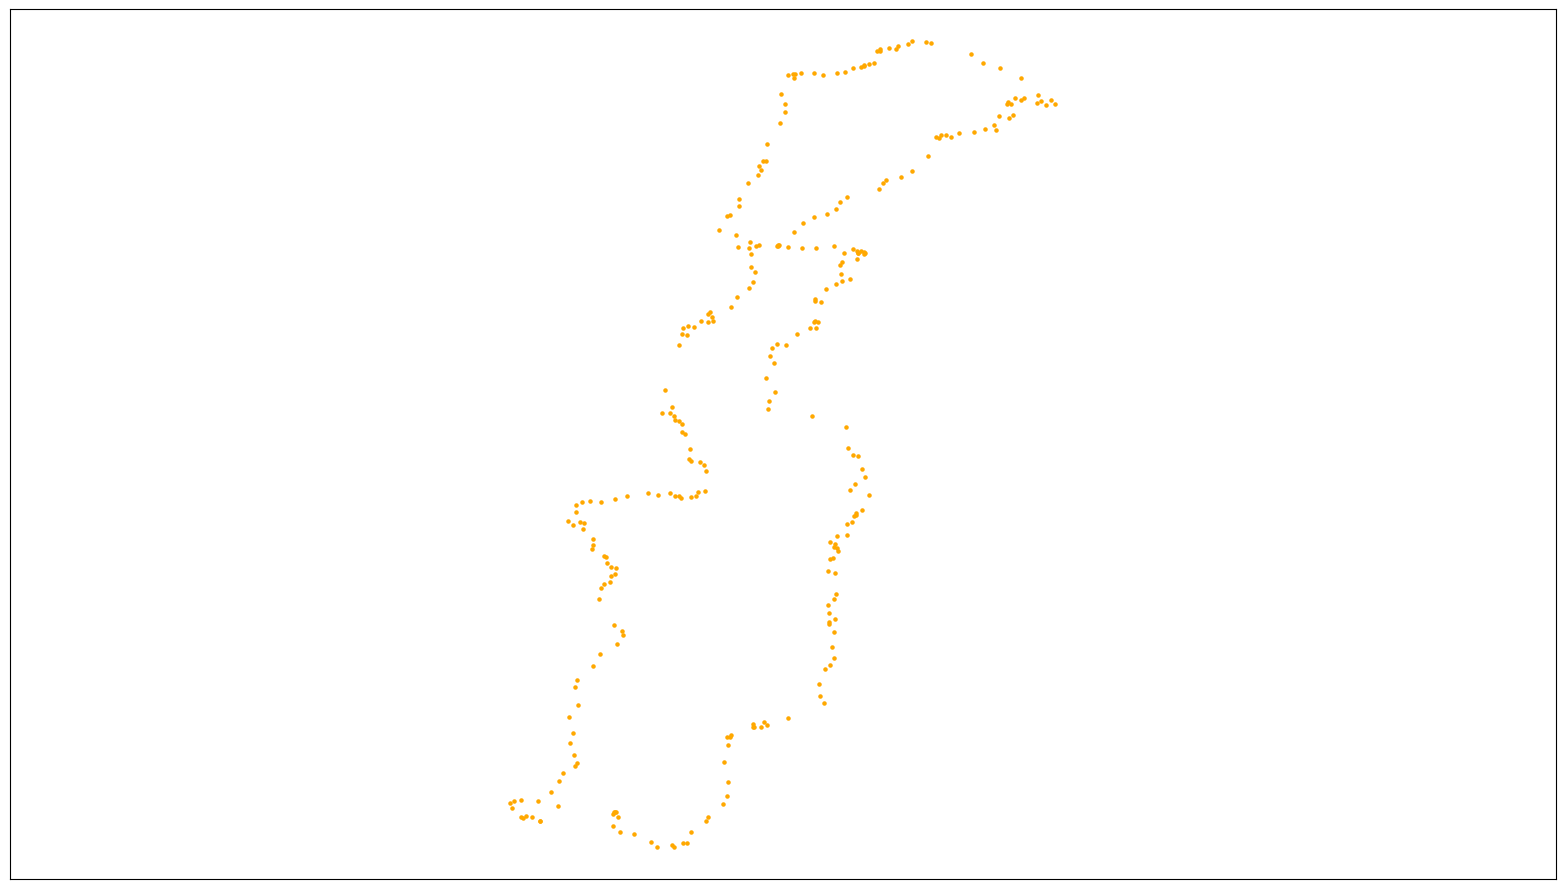

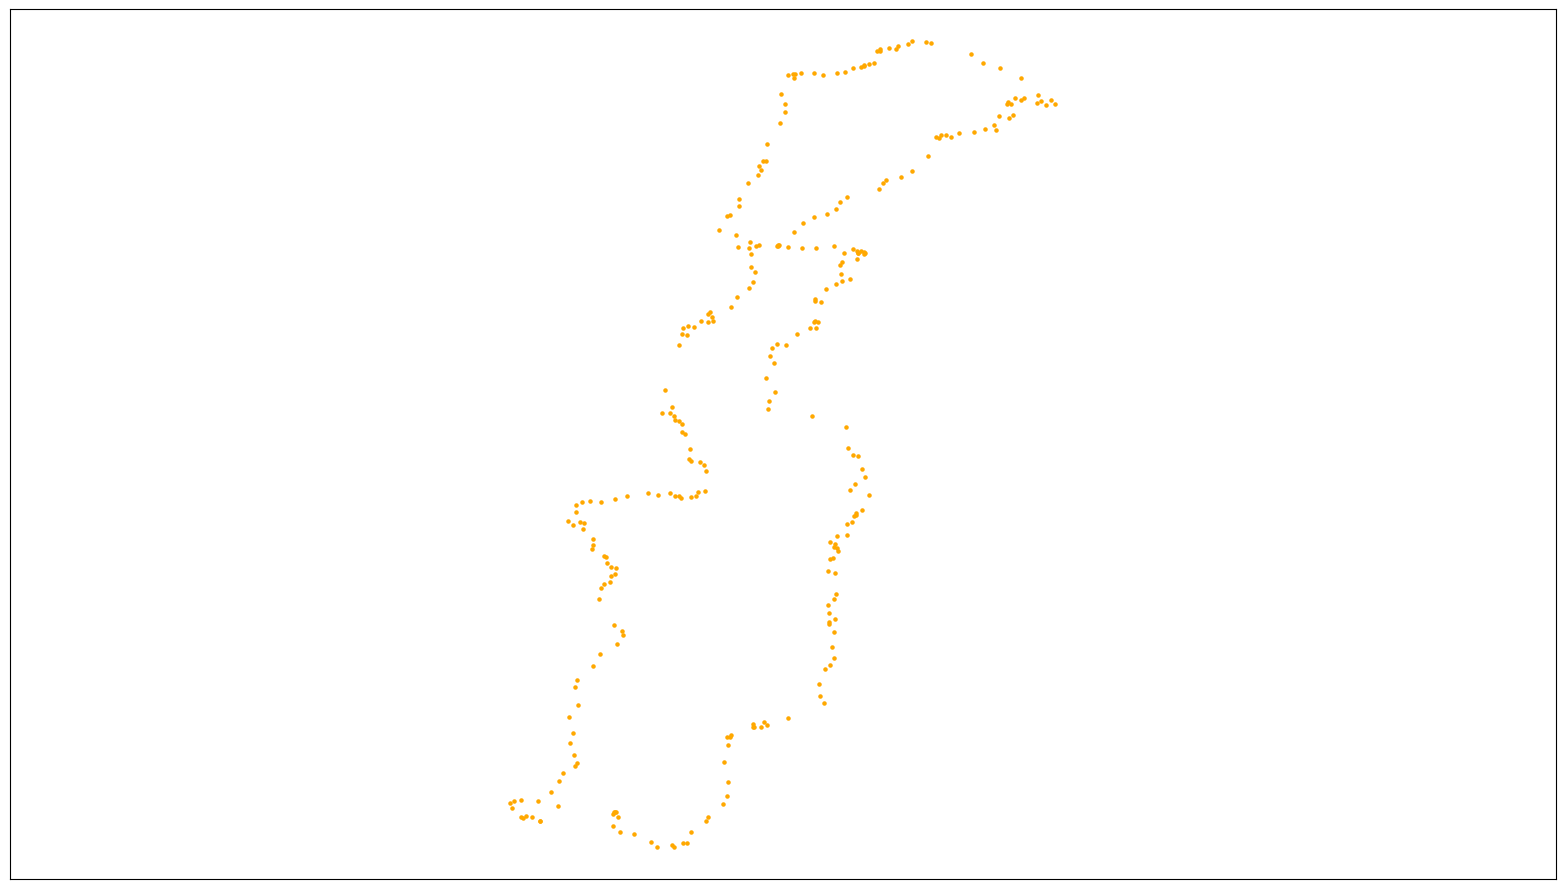

In [14]:
ezgpx.MatplotlibPlotter(gpx).plot()

In [ ]:
df_test = (
    df.select(["sport_type", "type", "distance", "start_date_local"])
    .sort("start_date_local")
    .with_columns(pl.col("start_date_local").dt.week().alias("week"))
    .drop("start_date_local")
    .group_by(["week", "sport_type"]).agg(pl.col("distance").sum()).sort("week")
)
df_test

In [ ]:
import plotly.express as px
run_df = df.filter(pl.col("type") == "Run")
fig = px.line(df, x="start_date_local", y="distance")
fig.show()

In [ ]:
df.to_dicts()

In [ ]:
# client.get_athlete_stats()
# client.get_athlete_zones()

In [ ]:
for kom in client.get_athlete_koms(athlete.id, limit=3):
    pprint(kom.model_dump())